# Chinook Records Store Database

In this project we will be working with a modified version of a database called Chinook. The Chinook database contains information about a fictional digital music shop - a smaller version of iTunes.  We will attempt to find patterns in the data and make business recommendations based on our observations.

The database contains information about the artists, songs, and albums from the music shop, as well as information on the shop's employees, customers, and their purchases. This information is contained in eleven tables. Here is a schema diagram for the Chinook database:

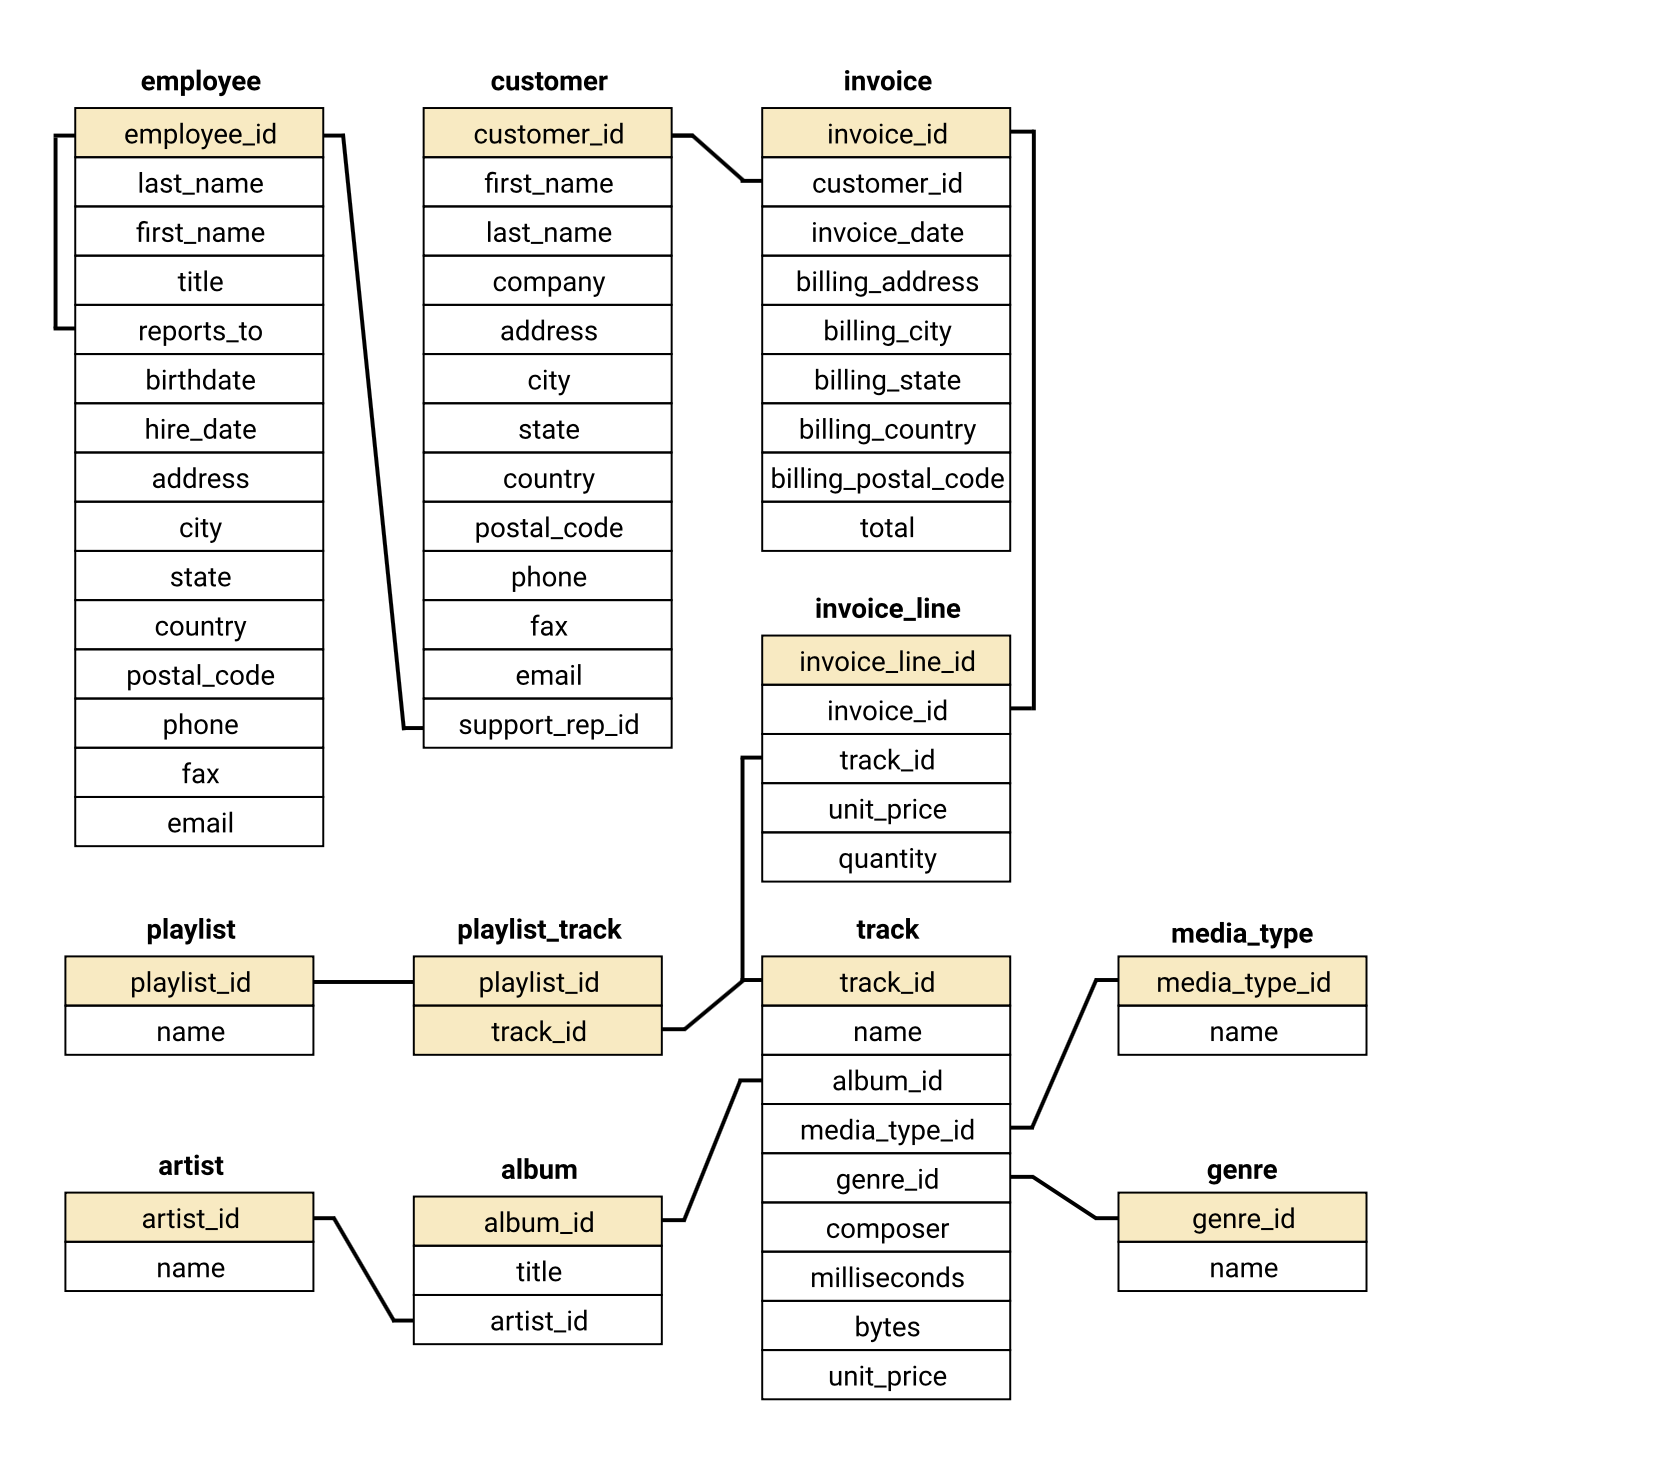

In [1]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db
# Connect to the database

In [2]:
# Import python libraries
import sqlite3 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
%%sql 
/*# Database overview */

SELECT name, type
  FROM sqlite_master
 WHERE type = 'table'

 * sqlite:///chinook.db
Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


## Sales Analysis By Country

Here we will display the following data for each country where customers have bought tracks in the store:

- total number of customers
- total sales
- average sales per customer
- average order value

Because there are several countries with only one customer we will group these into a row named "Other" and keep it on the bottom of the table after sorting.

In [4]:
%%sql
/*# Display aggregate sales data per country */

 WITH country_countrynew AS
     (
      SELECT country, 
             CASE
                 WHEN COUNT(DISTINCT customer_id) <= 1 THEN 'Other'
                 ELSE country
                 END
                 AS country_new
       FROM  customer
      GROUP BY country
     )

SELECT country_new AS country,
       COUNT(DISTINCT c.customer_id) AS customers,
       ROUND(SUM(i.total), 2) AS sales,
       ROUND(SUM(i.total) / COUNT(DISTINCT c.customer_id), 2) AS avg_sales_per_customer,
       ROUND(SUM(i.total) / COUNT(DISTINCT i.invoice_id), 2) AS avg_sales_per_order
 FROM customer c
INNER JOIN invoice as i ON i.customer_id = c.customer_id
INNER JOIN country_countrynew AS ccn ON ccn.country = c.country
GROUP BY country_new
ORDER BY (country_new='Other'), sales DESC;

 * sqlite:///chinook.db
Done.


country,customers,sales,avg_sales_per_customer,avg_sales_per_order
USA,13,1040.49,80.04,7.94
Canada,8,535.59,66.95,7.05
Brazil,5,427.68,85.54,7.01
France,5,389.07,77.81,7.78
Germany,4,334.62,83.66,8.16
Czech Republic,2,273.24,136.62,9.11
United Kingdom,3,245.52,81.84,8.77
Portugal,2,185.13,92.57,6.38
India,2,183.15,91.58,8.72
Other,15,1094.94,73.0,7.45


In [5]:
# Create variable to be passed into pd.read_sql
query_country = """WITH country_countrynew AS
     (
      SELECT country, 
             CASE
                 WHEN COUNT(DISTINCT customer_id) <= 1 THEN 'Other'
                 ELSE country
                 END
                 AS country_new
       FROM  customer
      GROUP BY country
     )

SELECT country_new AS country,
       COUNT(DISTINCT c.customer_id) AS customers,
       ROUND(SUM(i.total), 2) AS sales,
       ROUND(SUM(i.total) / COUNT(DISTINCT c.customer_id), 2) AS avg_sales_per_customer,
       ROUND(SUM(i.total) / COUNT(DISTINCT i.invoice_id), 2) AS avg_sales_per_order
 FROM customer c
INNER JOIN invoice as i ON i.customer_id = c.customer_id
INNER JOIN country_countrynew AS ccn ON ccn.country = c.country
GROUP BY country_new
ORDER BY (country_new='Other'), sales DESC;"""

# Connect to database
conn = sqlite3.connect('chinook.db')

# Read into dataframe
country_stats = pd.read_sql_query(query_country, conn)

# Reset index and create list of countries to pass as x-axis labels
country_stats = country_stats.set_index('country', drop=True)
country_list = country_stats.index.tolist()

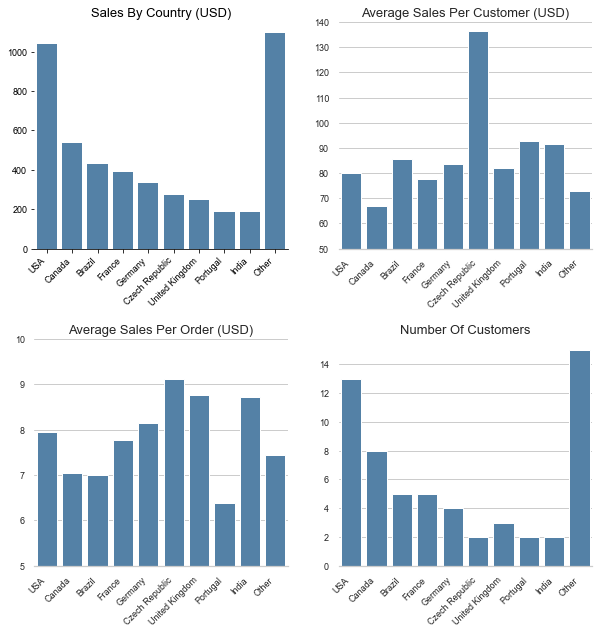

In [6]:
# Plot
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
fig.subplots_adjust(hspace=0.4)
plt.rcParams['figure.dpi'] = 460

ax1 = plt.subplot(2,2,1)
ax1 = sns.barplot(x=country_list,
                  y='sales',
                  data=country_stats,
                  color='steelblue')
ax1.set_title('Sales By Country (USD)', fontsize=13)
ax1.set_ylabel('')
ax1.tick_params(labelsize=9)
plt.xticks(rotation = 45, ha='right')
sns.despine(left=True)
sns.set(style='whitegrid')


ax2 = plt.subplot(2,2,2)
ax2 = sns.barplot(x=country_list,
                  y='avg_sales_per_customer',
                  data=country_stats,
                  color='steelblue')
ax2.set_title('Average Sales Per Customer (USD)', fontsize=13)
ax2.set_ylabel('')
ax2.set_ylim([50,140])
ax2.tick_params(labelsize=9)
plt.xticks(rotation = 45, ha='right')
sns.despine(left=True)
sns.set(style='whitegrid')

ax3 = plt.subplot(2,2,3)
ax3 = sns.barplot(x=country_list,
                  y='avg_sales_per_order',
                  data=country_stats,
                  color='steelblue')
ax3.set_title('Average Sales Per Order (USD)', fontsize=13)
ax3.set_ylabel('')
ax3.set_ylim([5,10])
ax3.tick_params(labelsize=9)
plt.xticks(rotation = 45, ha='right')
sns.despine(left=True)
sns.set(style='whitegrid')

ax4 = plt.subplot(2,2,4)
ax4 = sns.barplot(x=country_list,
                  y='customers',
                  data=country_stats,
                  color='steelblue')
ax4.set_title('Number Of Customers', fontsize=13)
ax4.set_ylabel('')
ax4.tick_params(labelsize=9)
plt.xticks(rotation = 45, ha='right')
sns.despine(left=True)
sns.set(style='whitegrid')

### Observations

- The United States has the most sales of any other country.
- Countries in the 'Other' category have more combined sales than the United States.
- Most customers spend between 70 and 90 dollars with the notable exception of our customers from the Czech Republic.
- The Czech Republic has the most sales per customer and the largest sales per order.  Since the country only has two customers, it is hard to conclude that customers from the Czech Republic spend more in general or if our two customers just happen to be big spenders.

## Measurements of Song Popularity

Next, will look at the follwing popularity metrics:

- genre popularity
- song appearances in playlists
- songs that never sell
- Digital Rights Management (DRM) protected vs. non-protected file types

### Genre Popularity

The Chinook record store has just signed a deal with a new record label, and they are considering three albums that will be added to the store from a list of four:

- Regal - Hip-Hop
- Red Tone - Punk
- Meteor and the Girls - Pop
- Slim Jim Bites - Blues

Since the record label specializes on artists from the USA we are interested in finding out which of these genres sell best in across the country.

In [7]:
%%sql
/*# Display all genres in the USA sorted by the number of tracks sold */

 WITH usa_tracks AS
     (
      SELECT t.genre_id AS genre_id, il.invoice_line_id
        FROM track as t
       INNER JOIN invoice_line as il ON il.track_id=t.track_id
       INNER JOIN invoice as i ON i.invoice_id = il.invoice_id
       WHERE i.billing_country = 'USA'
     )
    
SELECT g.name, 
       COUNT(usa.genre_id) AS tracks_sold,
       ROUND(CAST(COUNT(usa.genre_id) AS FLOAT)/ (SELECT COUNT(genre_id)
                                FROM usa_tracks),2) AS percentage
 FROM usa_tracks AS usa
INNER JOIN genre as g ON g.genre_id = usa.genre_id

GROUP BY g.name
ORDER BY tracks_sold DESC;

 * sqlite:///chinook.db
Done.


name,tracks_sold,percentage
Rock,561,0.53
Alternative & Punk,130,0.12
Metal,124,0.12
R&B/Soul,53,0.05
Blues,36,0.03
Alternative,35,0.03
Pop,22,0.02
Latin,22,0.02
Hip Hop/Rap,20,0.02
Jazz,14,0.01


Text(0.5, 0.95, 'Top Selling Genres (USA)')

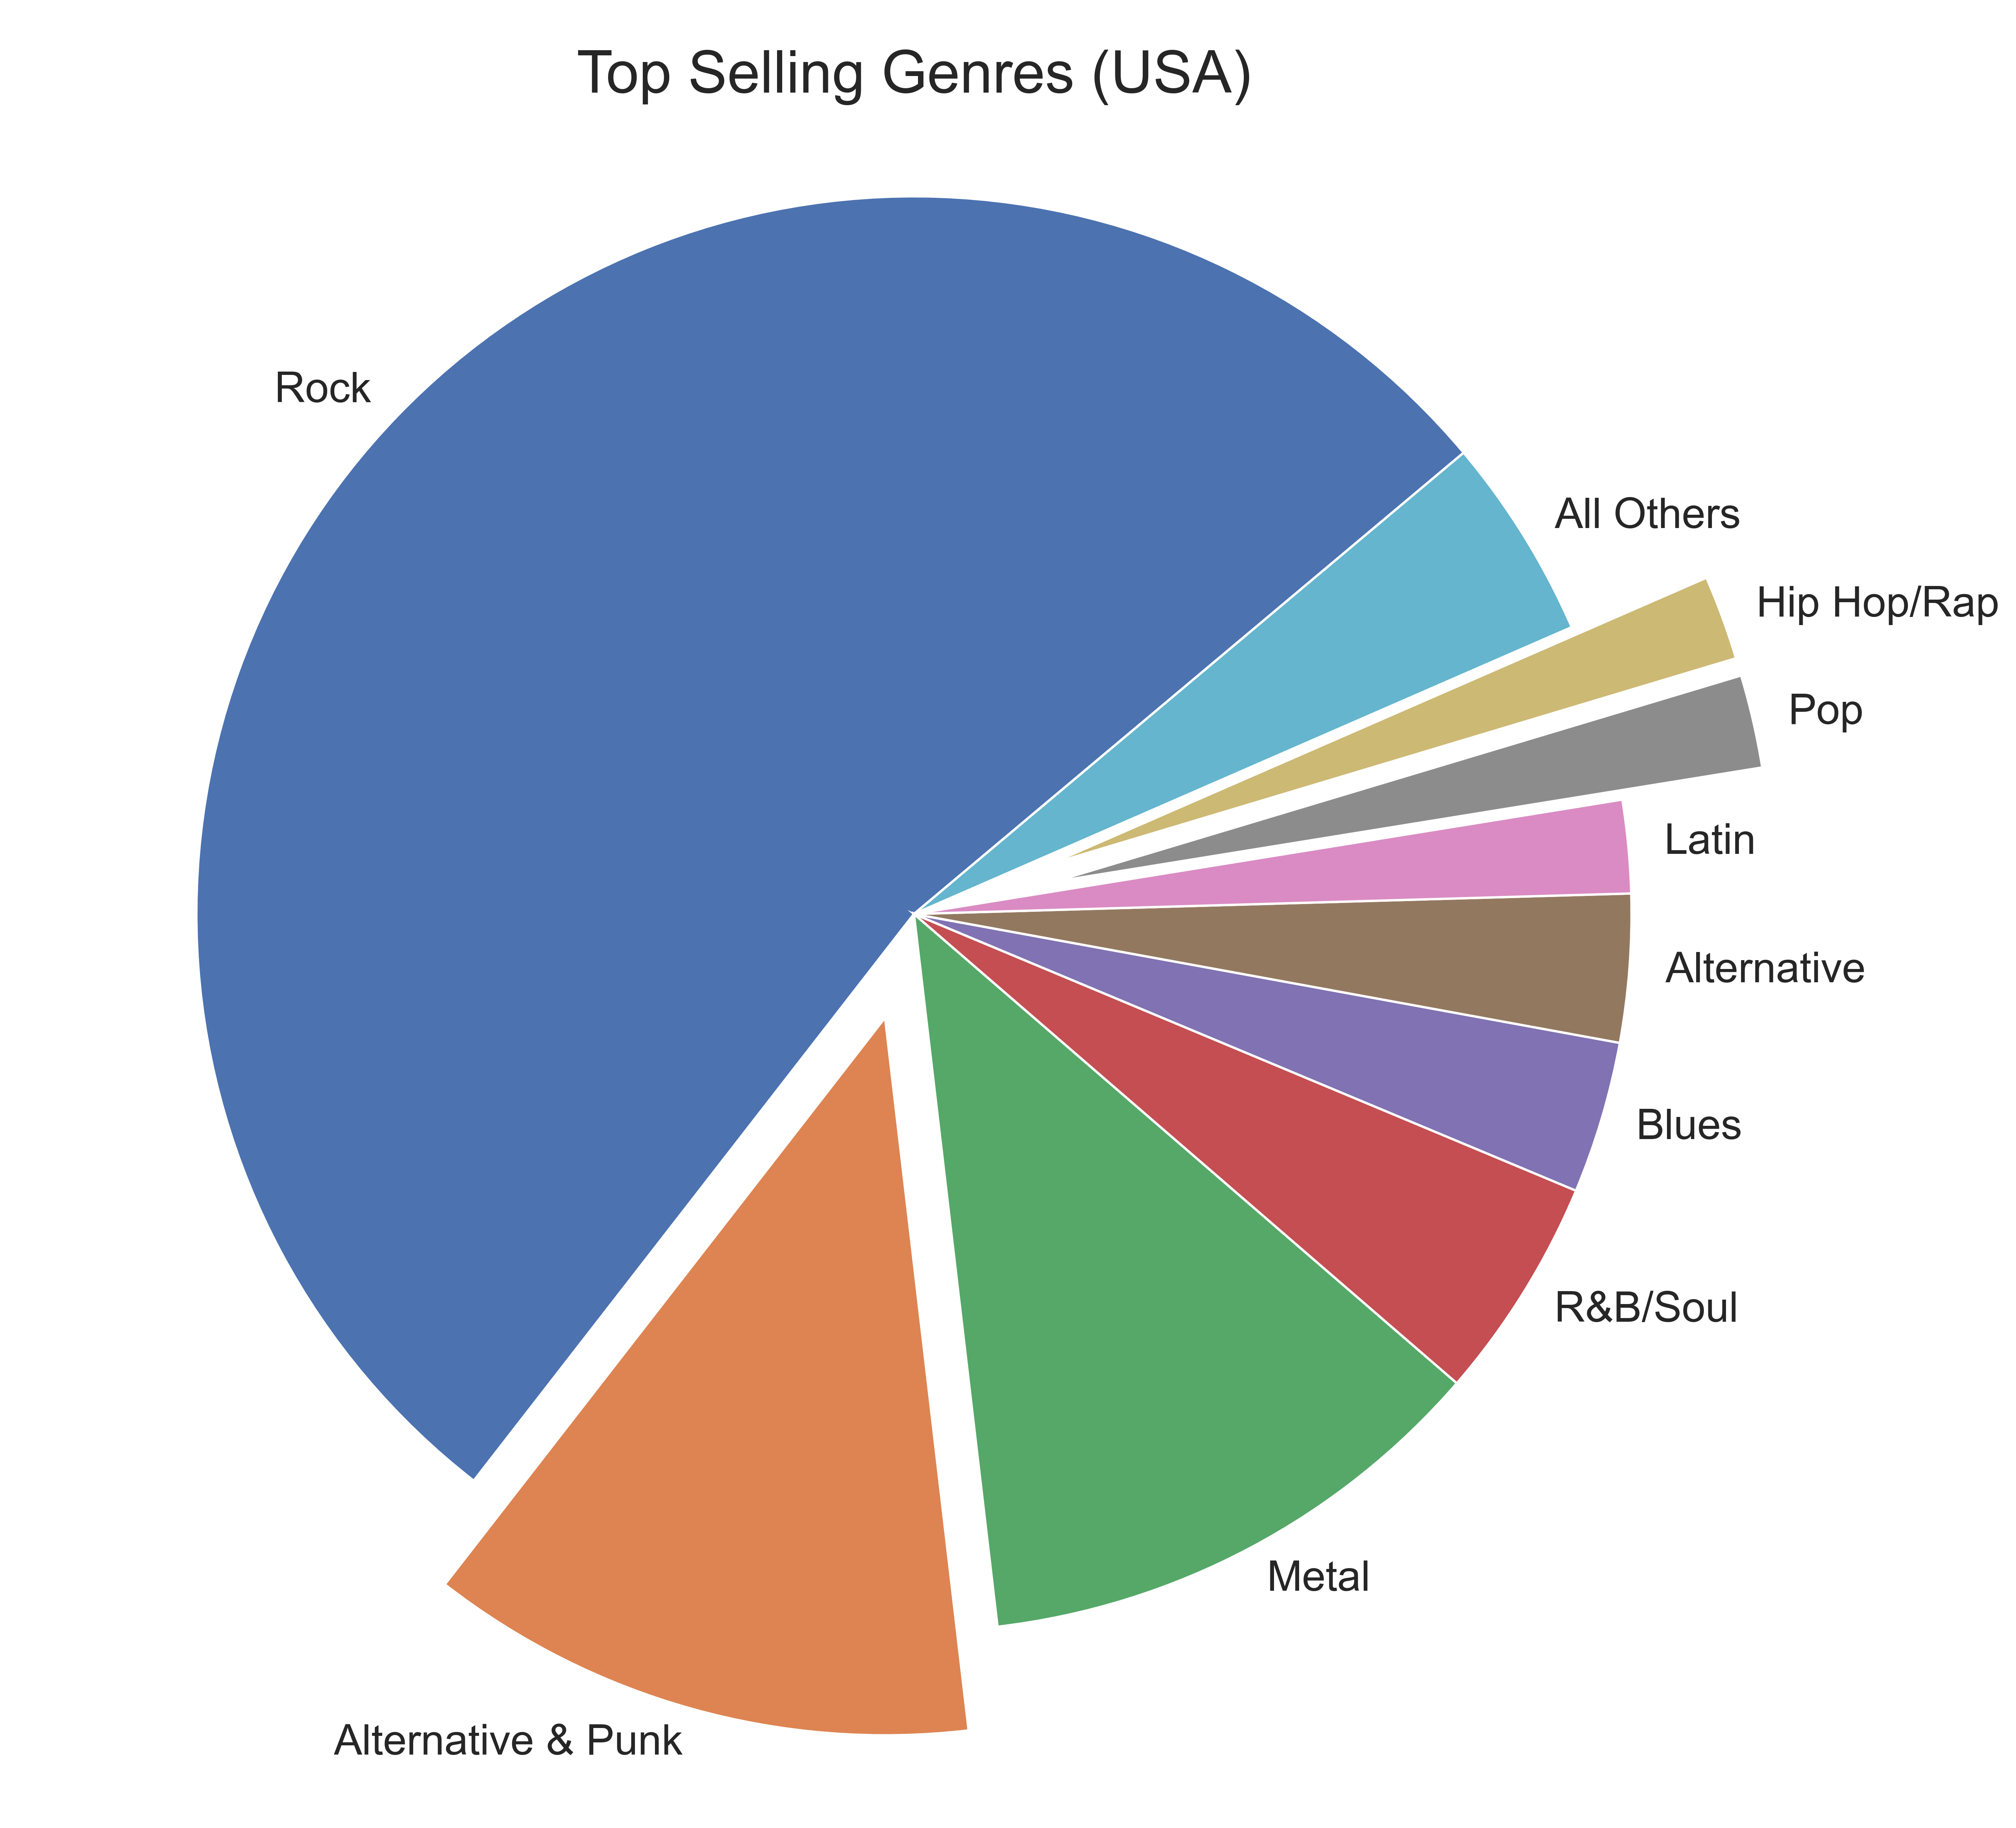

In [8]:
# Create variable to pass into pd.read_sql
query_genre = """ WITH usa_tracks AS
    (
     SELECT t.genre_id AS genre_id, il.invoice_line_id
       FROM track as t
      INNER JOIN invoice_line as il ON il.track_id=t.track_id
      INNER JOIN invoice as i ON i.invoice_id = il.invoice_id
      WHERE i.billing_country = 'USA'
    )
    
SELECT g.name, 
       COUNT(usa.genre_id) AS tracks_sold,
       ROUND(CAST(COUNT(usa.genre_id) AS FLOAT)/ (SELECT COUNT(genre_id)
                                FROM usa_tracks),2) AS percentage
 FROM usa_tracks AS usa
INNER JOIN genre as g ON g.genre_id = usa.genre_id

GROUP BY g.name
ORDER BY tracks_sold DESC;"""

# Connect to database
conn = sqlite3.connect('chinook.db')

# Read into dataframe
genre = pd.read_sql_query(query_genre, conn)

# Label genres with less than 20 tracks sold to 'All Others' for pie chart
genre['name'] = genre['name'].mask(genre['tracks_sold'] <20, 'All Others')

# Group, sort, and slice for the pie chart
genre = genre.groupby('name').sum()
genre = genre.sort_values(by='tracks_sold', ascending=False)
genre = genre.iloc[:,0]
genre

# Get 'All Others' to bottom of series for pie chart
genre = genre.drop('All Others')
temp = pd.Series(48)
temp = temp.rename({0:'All Others'})
genre = genre.append(temp)

explode = (0, 0.15, 0, 0, 0, 0, 0, 0.2, 0.2, 0)

# Plot
fig, ax = plt.subplots(figsize=(14,14))
genre.plot(kind='pie',
           fontsize=18,
           explode=explode,
           startangle=40,
           labeldistance=1.05)

# Plot Aesthetics
ax.set_ylabel('')
ax.set_title('Top Selling Genres (USA)',
             fontsize=25,
             y=0.95)

#### Observations:

- Based on this sales data, Chinook should sign Red Tone, Meteor and the Girls, Slim Jim Bites.
- The 'Alternative & Punk' and 'Alternative' categories seem to  be redundant.  The company should exmine this as it might be causing inaccurate categorization and data.

### Which Artists Have The Most Appearances In Playlists?

In [9]:
%%sql
/*# Breakdown of how many distinct tracks in each playlist */

SELECT playlist_id,
       COUNT(DISTINCT track_id) totals
  FROM playlist_track group by playlist_id
 ORDER BY totals DESC;

 * sqlite:///chinook.db
Done.


playlist_id,totals
1,3290
8,3290
5,1477
3,213
10,213
12,75
11,39
17,26
13,25
14,25


In [10]:
%%sql
/*# Display total isntances of an artist across all playlists */

  WITH artist_trackid AS 
       (
        SELECT a.name artist_name, 
               t.track_id
          FROM artist a
         INNER JOIN album alb ON alb.artist_id = a.artist_id
         INNER JOIN track t ON t.album_id = alb.album_id
       )

SELECT at.artist_name,
       COUNT(pt.playlist_id) tracks_in_playlists
  FROM artist_trackid AS at
 INNER JOIN playlist_track AS pt ON pt.track_id=at.track_id
 GROUP BY at.artist_name
 ORDER BY COUNT(pt.playlist_id) DESC
 LIMIT 10;

 * sqlite:///chinook.db
Done.


artist_name,tracks_in_playlists
Iron Maiden,516
U2,333
Metallica,296
Led Zeppelin,252
Deep Purple,226
Lost,184
Pearl Jam,177
Faith No More,145
Eric Clapton,145
Lenny Kravitz,143


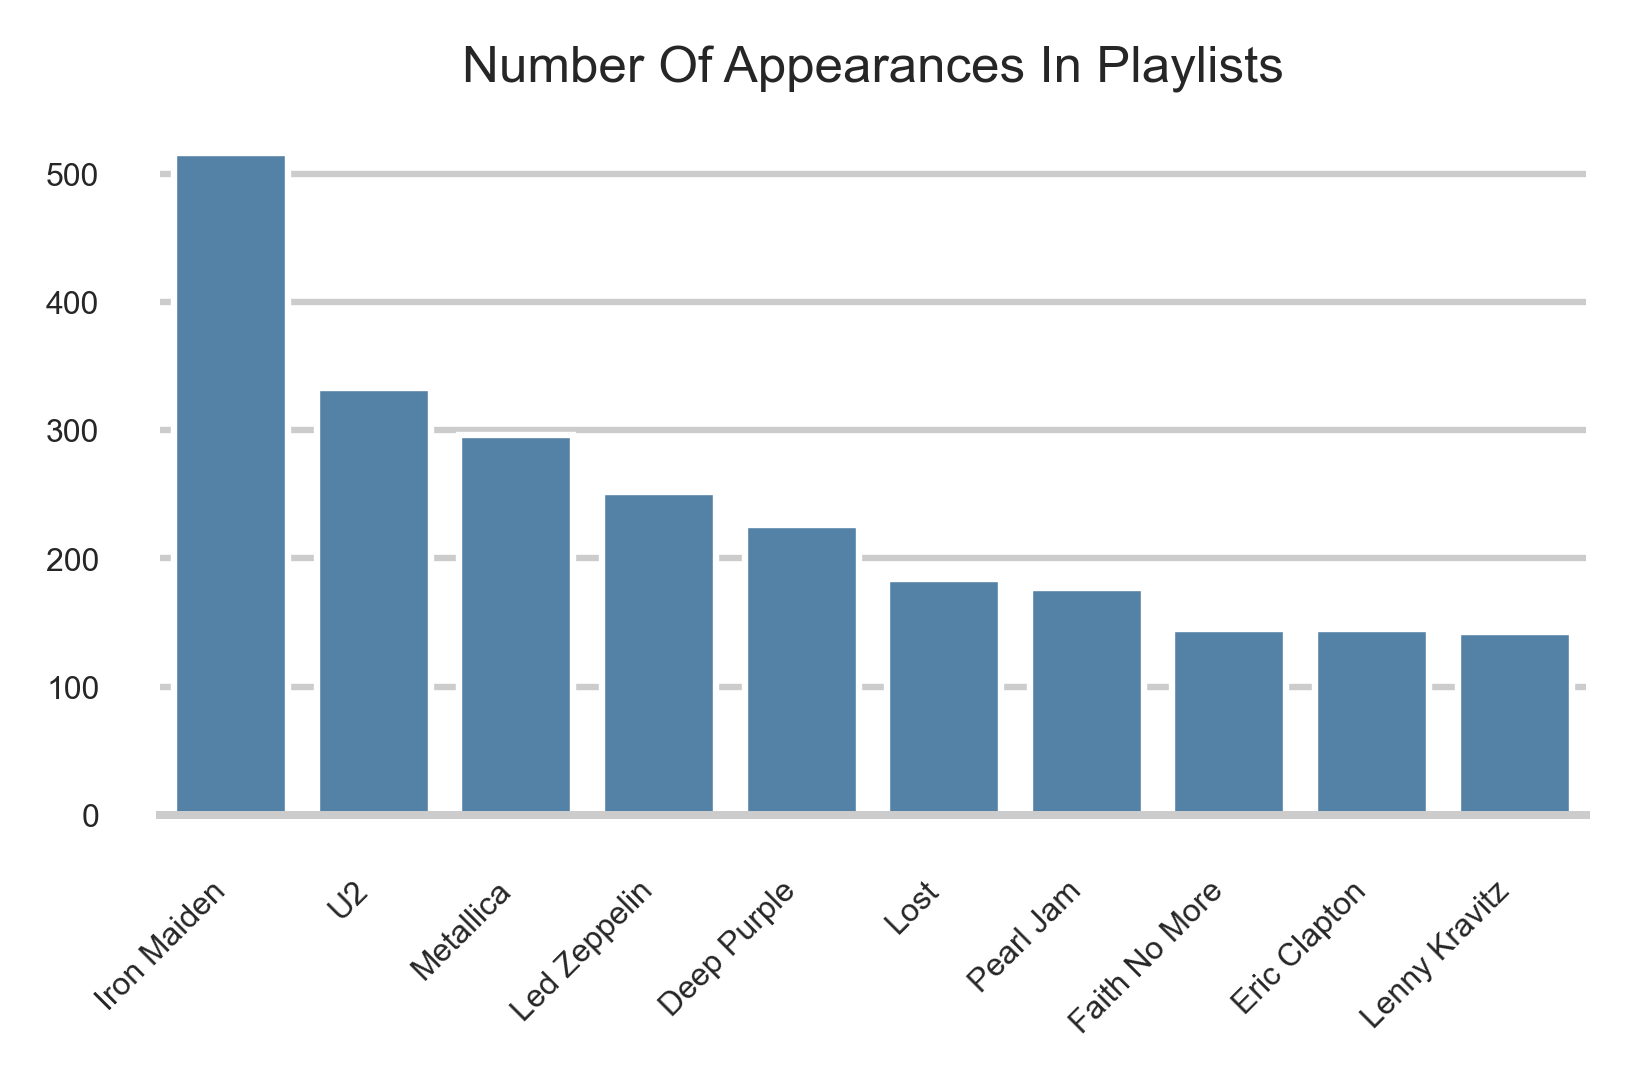

In [11]:
# Create variable to pass into pd.read_sql
query_playlists = """ WITH artist_trackid AS 
      (
       SELECT a.name artist_name, 
              t.track_id
         FROM artist a
        INNER JOIN album alb ON alb.artist_id = a.artist_id
        INNER JOIN track t ON t.album_id = alb.album_id
      )

SELECT at.artist_name,
       COUNT(pt.playlist_id) tracks_in_playlists
  FROM artist_trackid AS at
 INNER JOIN playlist_track AS pt ON pt.track_id=at.track_id
 GROUP BY at.artist_name
 ORDER BY COUNT(pt.playlist_id) DESC
 LIMIT 10;"""

# Connect to database
conn = sqlite3.connect('chinook.db')

# Read into dataframe
playlists = pd.read_sql_query(query_playlists, conn)

# Plot
fig, ax = plt.subplots(figsize=(4,2))
ax = sns.barplot(x='artist_name',
                 y='tracks_in_playlists',
                 data=playlists,
                 color='steelblue')

# Plot Aesthetics
ax.set_title('Number Of Appearances In Playlists', fontsize=8)
ax.set_ylabel('')
ax.set_xlabel('')
ax.tick_params(labelsize=5)
plt.xticks(rotation = 45, ha='right')
sns.despine(left=True)
sns.set(style='whitegrid')
plt.rcParams['figure.dpi'] = 460

#### Observations

- Iron Maiden has the most appearances across all the playlists with 516.  The next highest are U2, Metallica, & Led Zeppelin.
- There are only 14 playlists.
- A large majority of tracks are in two playlists with over 3,200 tracks each.

### How Many Tracks Never Sell? 

To answer this question, we will have to distriguish between the entire inventory of tracks in the ```track``` table and the distinct instances of tracks from the ```invoice_line``` table. 

In [12]:
%%sql
/*# Display the total amount of tracks available v. the total tracks purchased */

 WITH all_and_purchased AS
        (
         SELECT t.track_id all_tracks, il.track_id AS purchased_tracks
           FROM track AS t
           LEFT JOIN invoice_line il ON il.track_id=t.track_id
        )

SELECT COUNT(DISTINCT a.all_tracks) total_tracks,
       COUNT(DISTINCT a.purchased_tracks) tracks_purchased, 
       COUNT(DISTINCT a.all_tracks) - COUNT(DISTINCT a.purchased_tracks) not_purchased,
       ROUND(COUNT(DISTINCT a.purchased_tracks) / CAST(COUNT(DISTINCT a.all_tracks) AS float), 2)percent_purchased
 FROM all_and_purchased AS a;

 * sqlite:///chinook.db
Done.


total_tracks,tracks_purchased,not_purchased,percent_purchased
3503,1806,1697,0.52


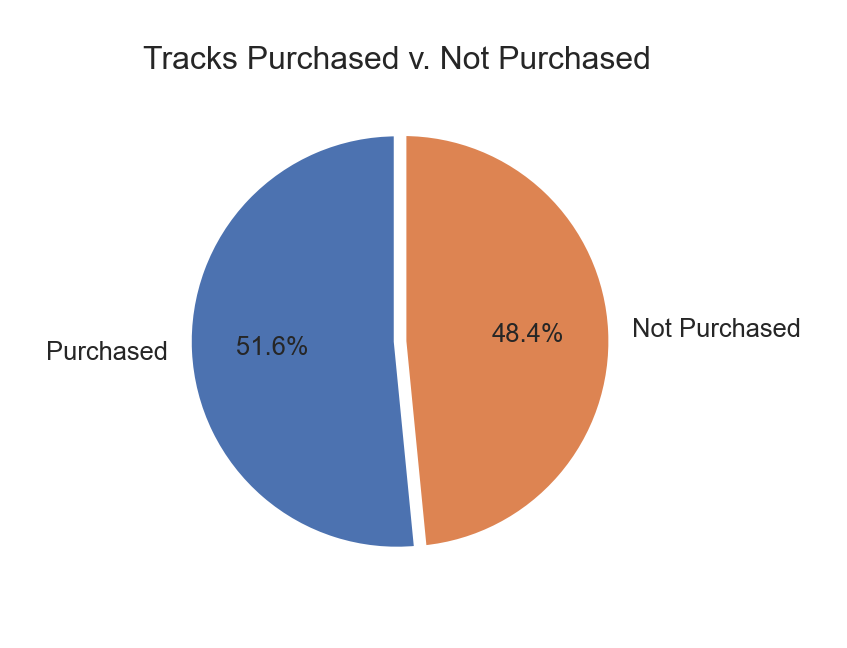

In [13]:
# Create variable to pass into pd.read_sql
query_purchased = """ WITH all_and_purchased AS
        (
         SELECT t.track_id all_tracks, il.track_id AS purchased_tracks
           FROM track AS t
           LEFT JOIN invoice_line il ON il.track_id=t.track_id
        )

SELECT COUNT(DISTINCT a.all_tracks) total_tracks,
       COUNT(DISTINCT a.purchased_tracks) tracks_purchased, 
       COUNT(DISTINCT a.all_tracks) - COUNT(DISTINCT a.purchased_tracks) not_purchased,
       ROUND(COUNT(DISTINCT a.purchased_tracks) / CAST(COUNT(DISTINCT a.all_tracks) AS float), 2)percent_purchased
FROM all_and_purchased AS a;"""

# Connect to database
conn = sqlite3.connect('chinook.db')

# Read into dataframe
purchased = pd.read_sql_query(query_purchased, conn)

# Transform dataframe and cast it to a list for plt.pie
purchased = purchased.T
purchased = purchased.iloc[[1,2],0]
purchased_list = purchased.tolist()

# Plot
plt.pie(purchased_list, 
        labels=('Purchased', 'Not Purchased'),
        explode=(0,0.03), 
        startangle=90,
        autopct='%1.1f%%',
        textprops={'fontsize': 4})

# Plot Aesthetics
plt.title('Tracks Purchased v. Not Purchased',
          fontsize=5,
          y=0.95)
fig = plt.gcf()
fig.set_size_inches(1.5,1.5)

#### Observations

- Suprisingly, almost half of the track inventory at Chinook has not sold.  Lets take a look at the bottom performers and see of we can learn more:

In [14]:
%%sql
/*# Display artists with zero units sold */

 SELECT ar.name artist_name,
        g.name genre,
        COUNT(il.track_id) units_sold
  FROM track t
  LEFT JOIN invoice_line il ON il.track_id = t.track_id
 INNER JOIN album al ON al.album_id = t.album_id
 INNER JOIN artist ar ON ar.artist_id = al.artist_id
 INNER JOIN genre as g ON g.genre_id = t.genre_id
 GROUP BY artist_name
HAVING units_sold = 0
 ORDER BY units_sold;

 * sqlite:///chinook.db
Done.


artist_name,genre,units_sold
Aaron Copland & London Symphony Orchestra,Classical,0
Academy of St. Martin in the Fields Chamber Ensemble & Sir Neville Marriner,Classical,0
"Academy of St. Martin in the Fields, John Birch, Sir Neville Marriner & Sylvia McNair",Classical,0
"Academy of St. Martin in the Fields, Sir Neville Marriner & Thurston Dart",Classical,0
Adrian Leaper & Doreen de Feis,Classical,0
Alberto Turco & Nova Schola Gregoriana,Classical,0
"Anne-Sophie Mutter, Herbert Von Karajan & Wiener Philharmoniker",Classical,0
Antal Doráti & London Symphony Orchestra,Classical,0
Aquaman,TV Shows,0
BackBeat,Rock And Roll,0


#### Observations

74 artists have 0 units sold.  Most of these tracks are classical music.  

Since the company purchases tracks from record companies to place in the store, half of the inventory (part of the working capital of the business) is stagnant and not producing a return.  

Although we do not know the financial arrangement between the company and the record label, we can offer recommandations based on two possible cases:

- If the company has paid a flat fee to host these tracks in the store, this is a sunk cost.  Moving forward, Chinook may want to stop signing these artists and focus on more popular genres.

- If the company pays the record label a percentage of sales, there is no real harm in keeping the tracks for sale in the store.


In either case, the company should consider finding a way to get these artists in front of the eyes of the customers.  Chinook could place suggestions for these artists on the webpage as the customer is purchasing other tracks or on the 'view cart' page.  This would increase exposure for the low-selling artists. 

### Protected v. Non-Protected Media Types:  Do Customers Care?

Any given track sold by Chinook is either protected or not protected.  This refers to the Digital Rights Managment properties of the track.  If it is protected, the purchaser is not able to make copies and is restricted to listening the the platform from which they bought it (iTunes for example).  An unprotected track allows the purchaser to make copies and listen to it wherever they wish.  

In Chinook protected tracks are identified by the following ```media_type_id```'s:

- Protected AAC audio file
- Protected MPEG-4 video file

Non-Protected tracks are identified by these ```media_type_id```'s:

- MPEG audio file
- Purchased AAC audio file
- AAC audio file

To find out whether the protected status of a tracks impacts the sales of the track, we will complete two steps:

First we will look at the entire inventory of tracks and determine the percentage of protected v. non-protected.  Then we will retreive the same percentage breakdown of tracks that have actaully sold (```track_id``` from the ```invoice_line``` table) and compare the two.

In [15]:
%%sql
/*# Display percentage breakdown from the entire track inventory */

WITH type_totals AS
        (
        SELECT  CASE
                    WHEN mt.name LIKE 'Protected%' THEN 'Protected'
                    ELSE 'Non-Protected'
                    END
                    AS type
        FROM track t 
        INNER JOIN media_type mt ON mt.media_type_id = t.media_type_id
        )

SELECT type, 
       COUNT(type) AS total,
       ROUND(COUNT(type) * 100.0 / (SELECT COUNT(*) FROM type_totals), 2) AS percentage
  FROM type_totals
 GROUP BY type;

 * sqlite:///chinook.db
Done.


type,total,percentage
Non-Protected,3052,87.13
Protected,451,12.87


In [16]:
%%sql
/*# Display percentage breakdown from just the tracks that have sold */

WITH type_totals AS
        (
        SELECT  CASE
                    WHEN mt.name LIKE 'Protected%' THEN 'Protected'
                    ELSE 'Non-Protected'
                    END
                    AS type
        FROM invoice_line il 
        INNER JOIN track t ON t.track_id = il.track_id
        INNER JOIN media_type mt ON mt.media_type_id = t.media_type_id
        )

SELECT type, 
       COUNT(type) AS total,
       ROUND(COUNT(type) * 100.0 / (SELECT COUNT(*) FROM type_totals), 2) AS percentage
  FROM type_totals
 GROUP BY type;

 * sqlite:///chinook.db
Done.


type,total,percentage
Non-Protected,4315,90.71
Protected,442,9.29


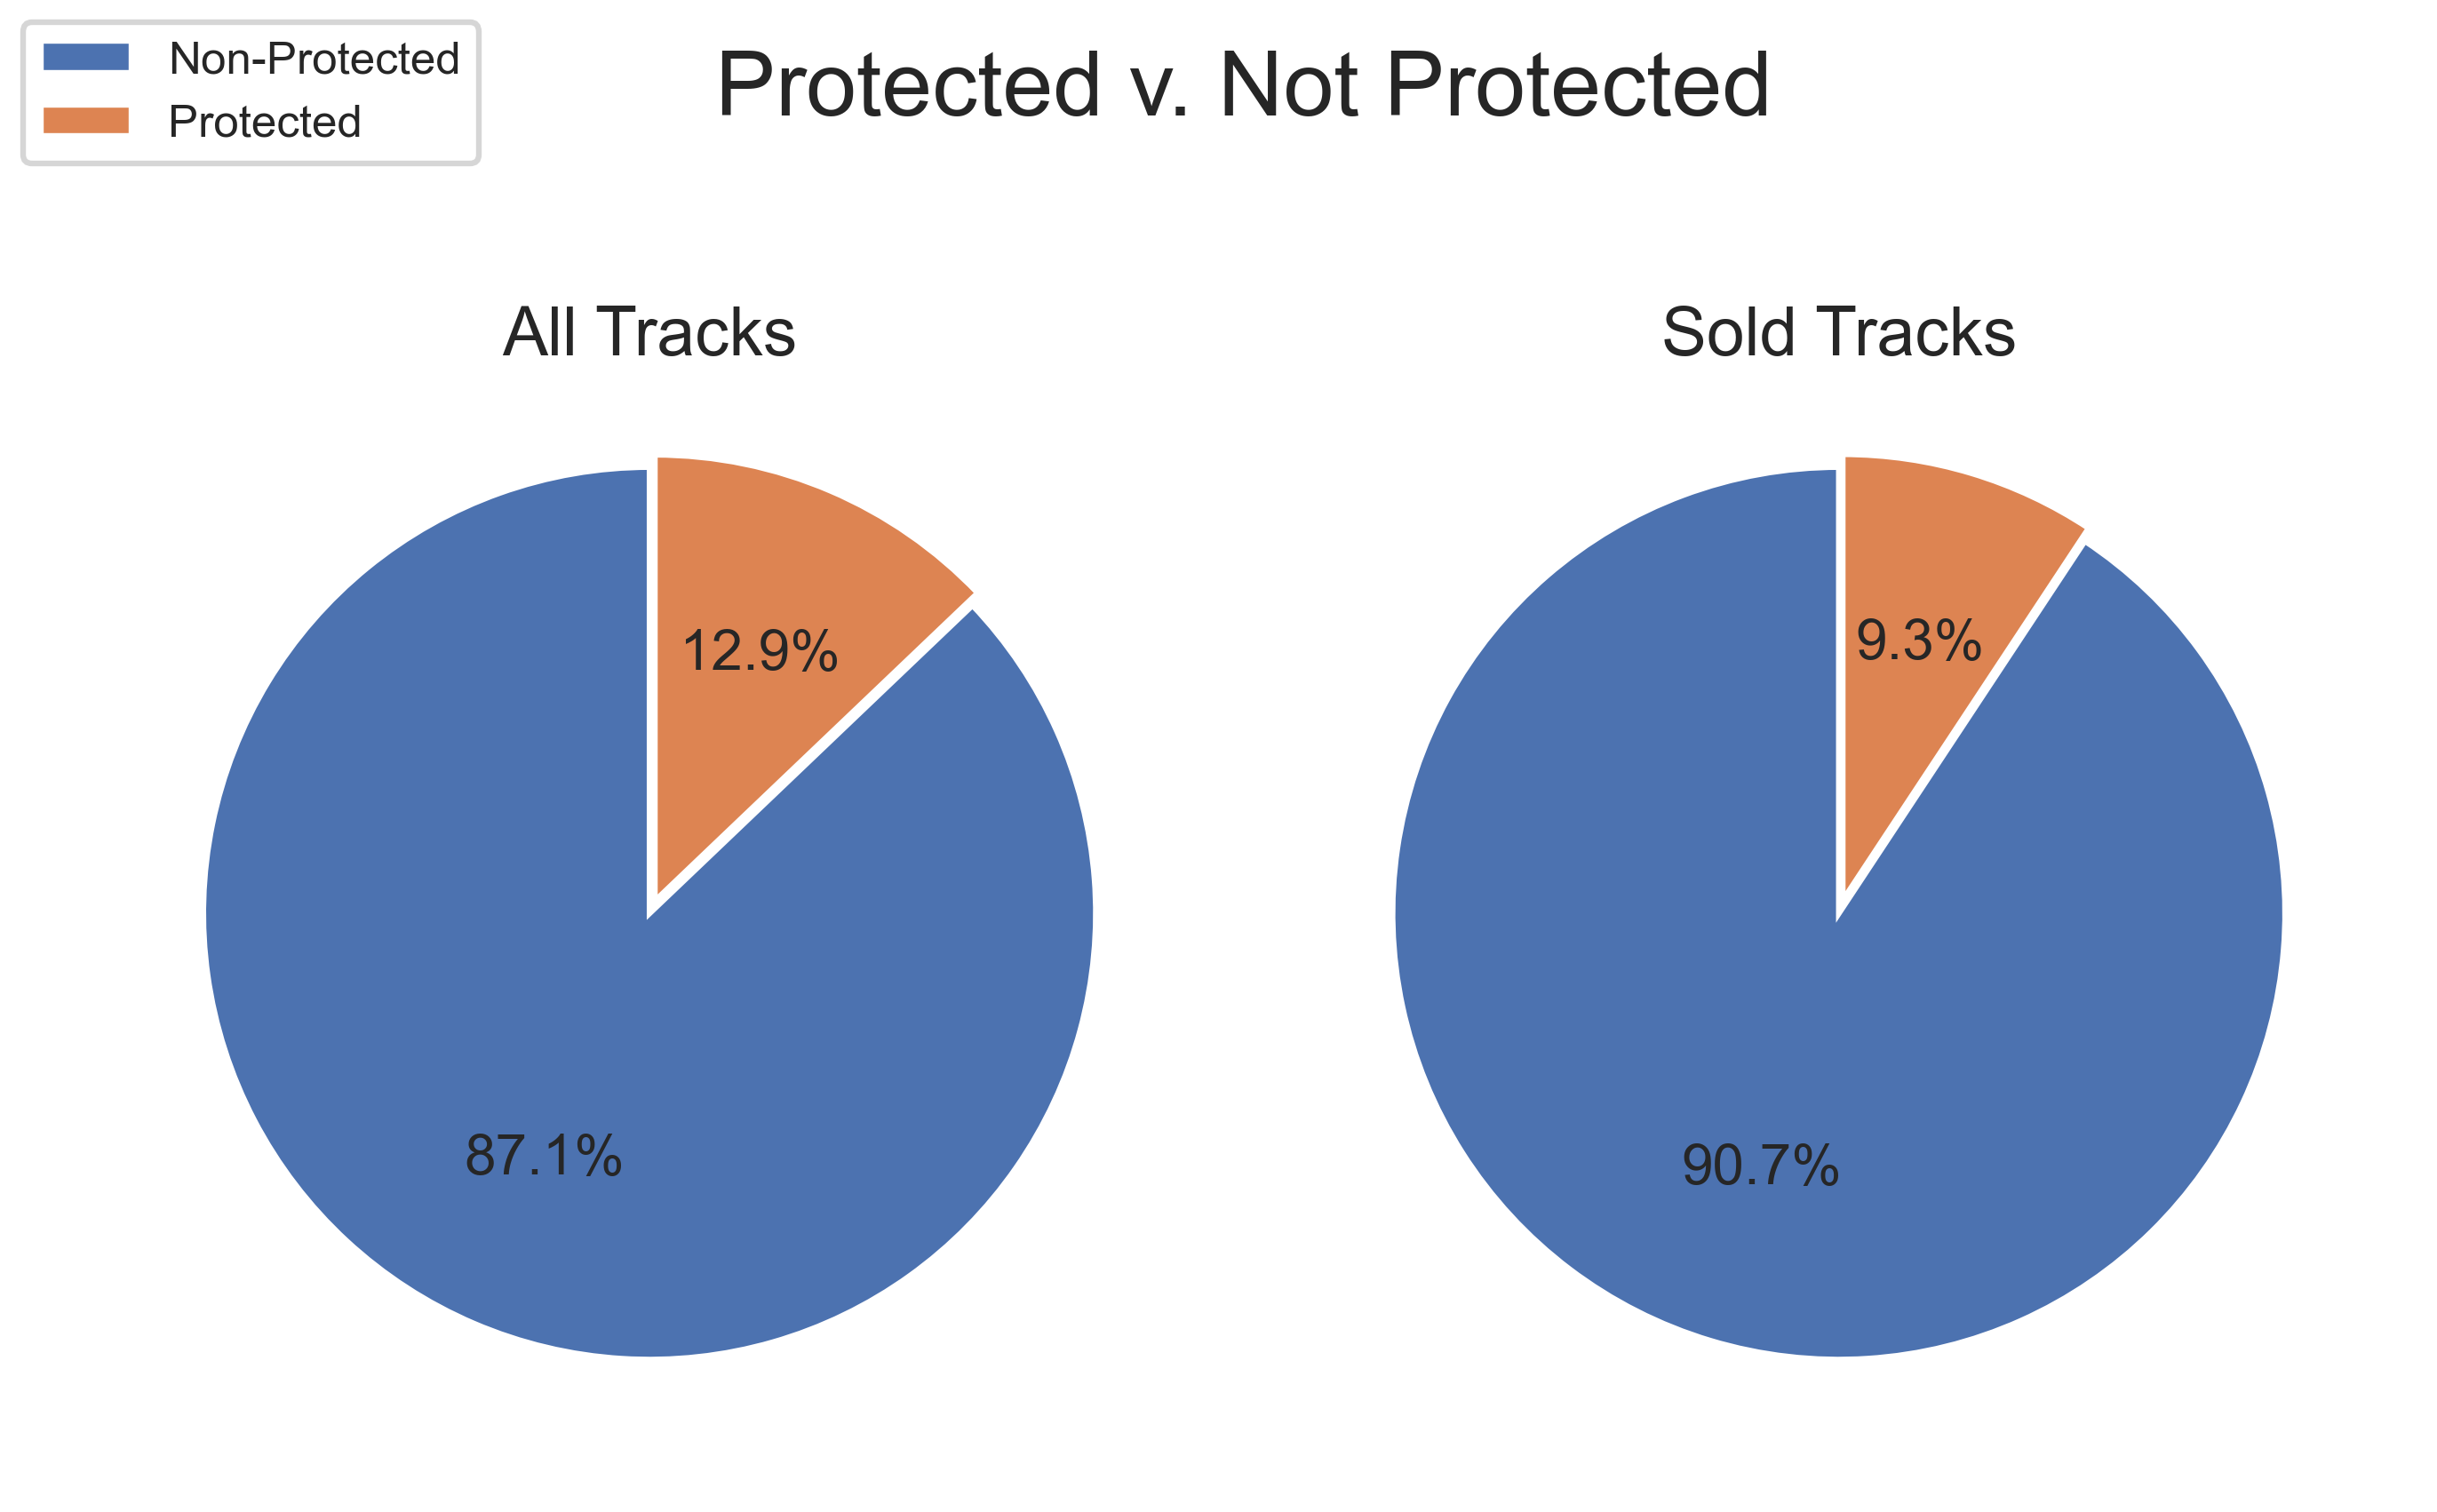

In [17]:
# Create variable for sold tracks to pass into pd.read_sql
query_protected_sold = """ WITH type_totals AS
        (
        SELECT  CASE
                    WHEN mt.name LIKE 'Protected%' THEN 'Protected'
                    ELSE 'Non-Protected'
                    END
                    AS type
        FROM invoice_line il 
        INNER JOIN track t ON t.track_id = il.track_id
        INNER JOIN media_type mt ON mt.media_type_id = t.media_type_id
        )

SELECT type, 
       COUNT(type) AS total,
       ROUND(COUNT(type) * 100.0 / (SELECT COUNT(*) FROM type_totals), 2) AS percentage
  FROM type_totals
 GROUP BY type;"""

# Create variable for all tracks to pass into pd.read_sql
query_protected_all = """WITH type_totals AS
        (
        SELECT  CASE
                    WHEN mt.name LIKE 'Protected%' THEN 'Protected'
                    ELSE 'Non-Protected'
                    END
                    AS type
        FROM track t 
        INNER JOIN media_type mt ON mt.media_type_id = t.media_type_id
        )

SELECT type, 
       COUNT(type) AS total,
       ROUND(COUNT(type) * 100.0 / (SELECT COUNT(*) FROM type_totals), 2) AS percentage
  FROM type_totals
 GROUP BY type;"""

# Connect to database
conn = sqlite3.connect('chinook.db')

# Read into dataframe
protected_sold = pd.read_sql_query(query_protected_sold, conn)
protected_all = pd.read_sql_query(query_protected_all, conn)

# Transform sold dataframe and cast it to a list for plt.pie
protected_sold = protected_sold.set_index('type')
protected_sold = protected_sold.iloc[[0,1],0]
list_sold = protected_sold.tolist()

# Transform all dataframe and cast it to a list for plt.pie
protected_all = protected_all.set_index('type')
protected_all = protected_all.iloc[[0,1],0]
list_all = protected_all.tolist()

# Plot
fig, (ax1, ax2) = plt.subplots(1,2)

patches, texts, autotexts = ax1.pie(list_all,
        explode=(0,0.03), 
        startangle=90,
        autopct='%1.1f%%',
        textprops={'fontsize': 10})

patches, texts, autotexts = ax2.pie(list_sold,
        explode=(0,0.03), 
        startangle=90,
        autopct='%1.1f%%',
        textprops={'fontsize': 10})

# Plot Aesthetics
ax1.set_title('All Tracks', y=0.97)
ax2.set_title('Sold Tracks', y=0.97)
fig.suptitle('Protected v. Not Protected', fontsize=16)
fig.legend(protected_sold.index, loc='upper left', prop={'size': 8})
plt.tight_layout()

#### Observations

- Customers do not seem to make purchasing descisions based on the protected status of a track.
- The percentage breakdown is nearly equal.  There is a slight bias towards non-protected tracks from the sales pool but it may be because more popular tracks tend to be non-protected.

## Entire Album Purchases vs. Seperate Track Purchases

The store is setup in a way that allows customer to make purchases in one of the two ways:

- purchase a whole album
- purchase a collection of one or more individual tracks.

The store does not let customers purchase a whole album and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

We are not going to consider the following uncommon situations:

- Albums that have only one or two tracks are likely to be purchased by customers as part of a collection of individual tracks.
- Customers may decide to manually select every track from an album, and then add a few individual tracks from other albums to their purchase.

Since our analysis is concerned with maximizing revenue we can safely ignore albums consisting of only a few tracks. The company has previously done analysis to confirm that the second situation does not happen often, so we can ignore this.

In order to answer the question, we're going to have to identify whether each invoice has all the tracks from an album. We can do this by getting the list of tracks from an invoice and comparing it to the list of tracks from an album. We can find the album to compare the purchase to by looking up the album that one of the purchased tracks belongs to. It doesn't matter which track we pick, since if it's an album purchase, that album will be the same for all tracks.

In [18]:
%%sql
/*# This will serve as a reference table.  */
/*# It has every every invoice_id with the album_id from one track in the order. */

CREATE VIEW album_per_invoice AS
SELECT il.invoice_id,                                     
       t.album_id
  FROM invoice_line il
  LEFT JOIN track t ON t.track_id = il.track_id
 GROUP BY il.invoice_id;

 * sqlite:///chinook.db
(sqlite3.OperationalError) table album_per_invoice already exists
[SQL: /*# This will serve as a reference table.  */
/*# It has every every invoice_id with the album_id from one track in the order. */

CREATE VIEW album_per_invoice AS
SELECT il.invoice_id,                                     
       t.album_id
  FROM invoice_line il
  LEFT JOIN track t ON t.track_id = il.track_id
 GROUP BY il.invoice_id;]
(Background on this error at: http://sqlalche.me/e/13/e3q8)


In [19]:
%%sql
SELECT * FROM album_per_invoice LIMIT 5;

 * sqlite:///chinook.db
Done.


invoice_id,album_id
1,91
2,322
3,203
4,314
5,163


We are going to take our above ```album_per_invoice``` view and append a new column that tells us whether the customer bought an entire album or just individual tracks.  In order to do this we are going to look at the tracks purchased on every ```invoice_id``` (tracks from the ```invoice_line``` table) and compare that to all the tracks an that particular album (tracks from the ```track``` table).

In [20]:
%%sql
/*# Appending new column with the label 'Full Album' or 'Individual Tracks' */

CREATE VIEW invoice_purchase_type AS
SELECT ai.invoice_id,
      CASE
      WHEN (SELECT il.track_id 
              FROM invoice_line il
             WHERE il.invoice_id = ai.invoice_id
            EXCEPT                                          
            SELECT t.track_id 
              FROM track t
             WHERE t.album_id = ai.album_id) IS NULL

      AND (SELECT t.track_id 
             FROM track t
            WHERE t.album_id = ai.album_id                                         
           EXCEPT                                          
           SELECT il.track_id 
             FROM invoice_line il
            WHERE il.invoice_id = ai.invoice_id) IS NULL
      THEN 'Full Album'
      ELSE 'Individual Tracks'
       END AS purchase_type                             
FROM album_per_invoice ai;

 * sqlite:///chinook.db
(sqlite3.OperationalError) table invoice_purchase_type already exists
[SQL: /*# Appending new column with the label 'Full Album' or 'Individual Tracks' */

CREATE VIEW invoice_purchase_type AS
SELECT ai.invoice_id,
      CASE
      WHEN (SELECT il.track_id 
              FROM invoice_line il
             WHERE il.invoice_id = ai.invoice_id
            EXCEPT                                          
            SELECT t.track_id 
              FROM track t
             WHERE t.album_id = ai.album_id) IS NULL

      AND (SELECT t.track_id 
             FROM track t
            WHERE t.album_id = ai.album_id                                         
           EXCEPT                                          
           SELECT il.track_id 
             FROM invoice_line il
            WHERE il.invoice_id = ai.invoice_id) IS NULL
      THEN 'Full Album'
      ELSE 'Individual Tracks'
       END AS purchase_type                             
FROM album_per_invoice ai;]

In [21]:
%%sql
SELECT * FROM invoice_purchase_type LIMIT 5;

 * sqlite:///chinook.db
Done.


invoice_id,purchase_type
1,Full Album
2,Individual Tracks
3,Individual Tracks
4,Individual Tracks
5,Full Album


In [22]:
%%sql
SELECT purchase_type, 
       COUNT(invoice_id) AS total,
       ROUND(COUNT(invoice_id) * 100.0 / (SELECT COUNT(*) FROM invoice_purchase_type), 2) AS percentage
  FROM invoice_purchase_type
 GROUP BY purchase_type;

 * sqlite:///chinook.db
Done.


purchase_type,total,percentage
Full Album,114,18.57
Individual Tracks,500,81.43


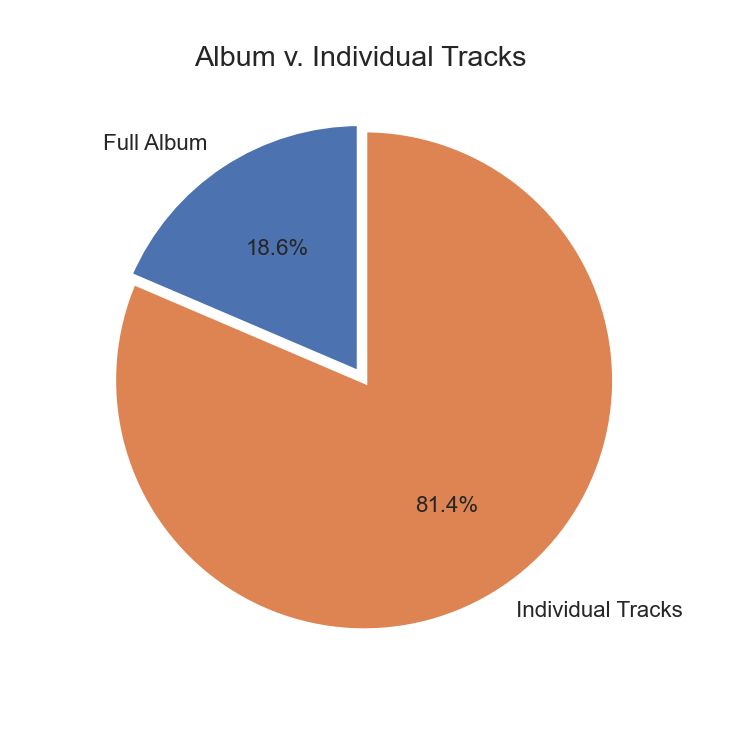

In [23]:
# Create variable to pass into pd.read_sql
query_album = """SELECT purchase_type, 
       COUNT(invoice_id) AS total,
       ROUND(COUNT(invoice_id) * 100.0 / (SELECT COUNT(*) FROM invoice_purchase_type), 2) AS percentage
 FROM invoice_purchase_type
GROUP BY purchase_type;"""

# Connect to database
conn = sqlite3.connect('chinook.db')

# Read into dataframe
album = pd.read_sql_query(query_album, conn)

# Transform dataframe and cast it to a list
album = album.set_index('purchase_type')
album = album.iloc[[0,1],0]
album_list = album.tolist()

# Plot
plt.pie(album_list, 
        labels=album.index,
        explode=(0,0.03), 
        startangle=90,
        autopct='%1.1f%%',
        textprops={'fontsize': 3.5})

# Plot Aesthetics
plt.tight_layout()
plt.title('Album v. Individual Tracks', fontsize=4.5, y=0.93)
fig = plt.gcf()
fig.set_size_inches(1.5,1.5)

#### Observations

- The vast majority of purchases are of single tracks only.
- Only 18.57% of the purchases are of an entire album.

Based on this we would recommend to managment that they move forward with their plan to start purchasing the most popular tracks from an album instead of the entire album.  Over 80% of customers would likely not be impacted by this change. At the same time the company would be reducing its purchasing expenses.  

The impact to album-buying cusomters could be mitigated by keeping an inventory of albums from popular artists, genres, or record labels only.

## Employee Sales Performance

Each customer for the Chinook store gets assigned to a sales support agent. We will analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

In [24]:
%%sql
/*# Display employee sales data as well as hire date */

WITH employee_sales AS
   (
    SELECT c.support_rep_id,
           ROUND(SUM(i.total), 2) AS rep_total,
           COUNT(c.customer_id) total_customers
      FROM invoice AS i
     INNER JOIN customer AS c ON c.customer_id=i.customer_id
     GROUP BY c.support_rep_id
   )

SELECT e.first_name||" "||e.last_name AS employee_name,
       es.rep_total,
       e.hire_date
  FROM employee_sales AS es
 INNER JOIN employee AS e ON e.employee_id=es.support_rep_id;

 * sqlite:///chinook.db
Done.


employee_name,rep_total,hire_date
Jane Peacock,1731.51,2017-04-01 00:00:00
Margaret Park,1584.0,2017-05-03 00:00:00
Steve Johnson,1393.92,2017-10-17 00:00:00


<Figure size 1840x1380 with 0 Axes>

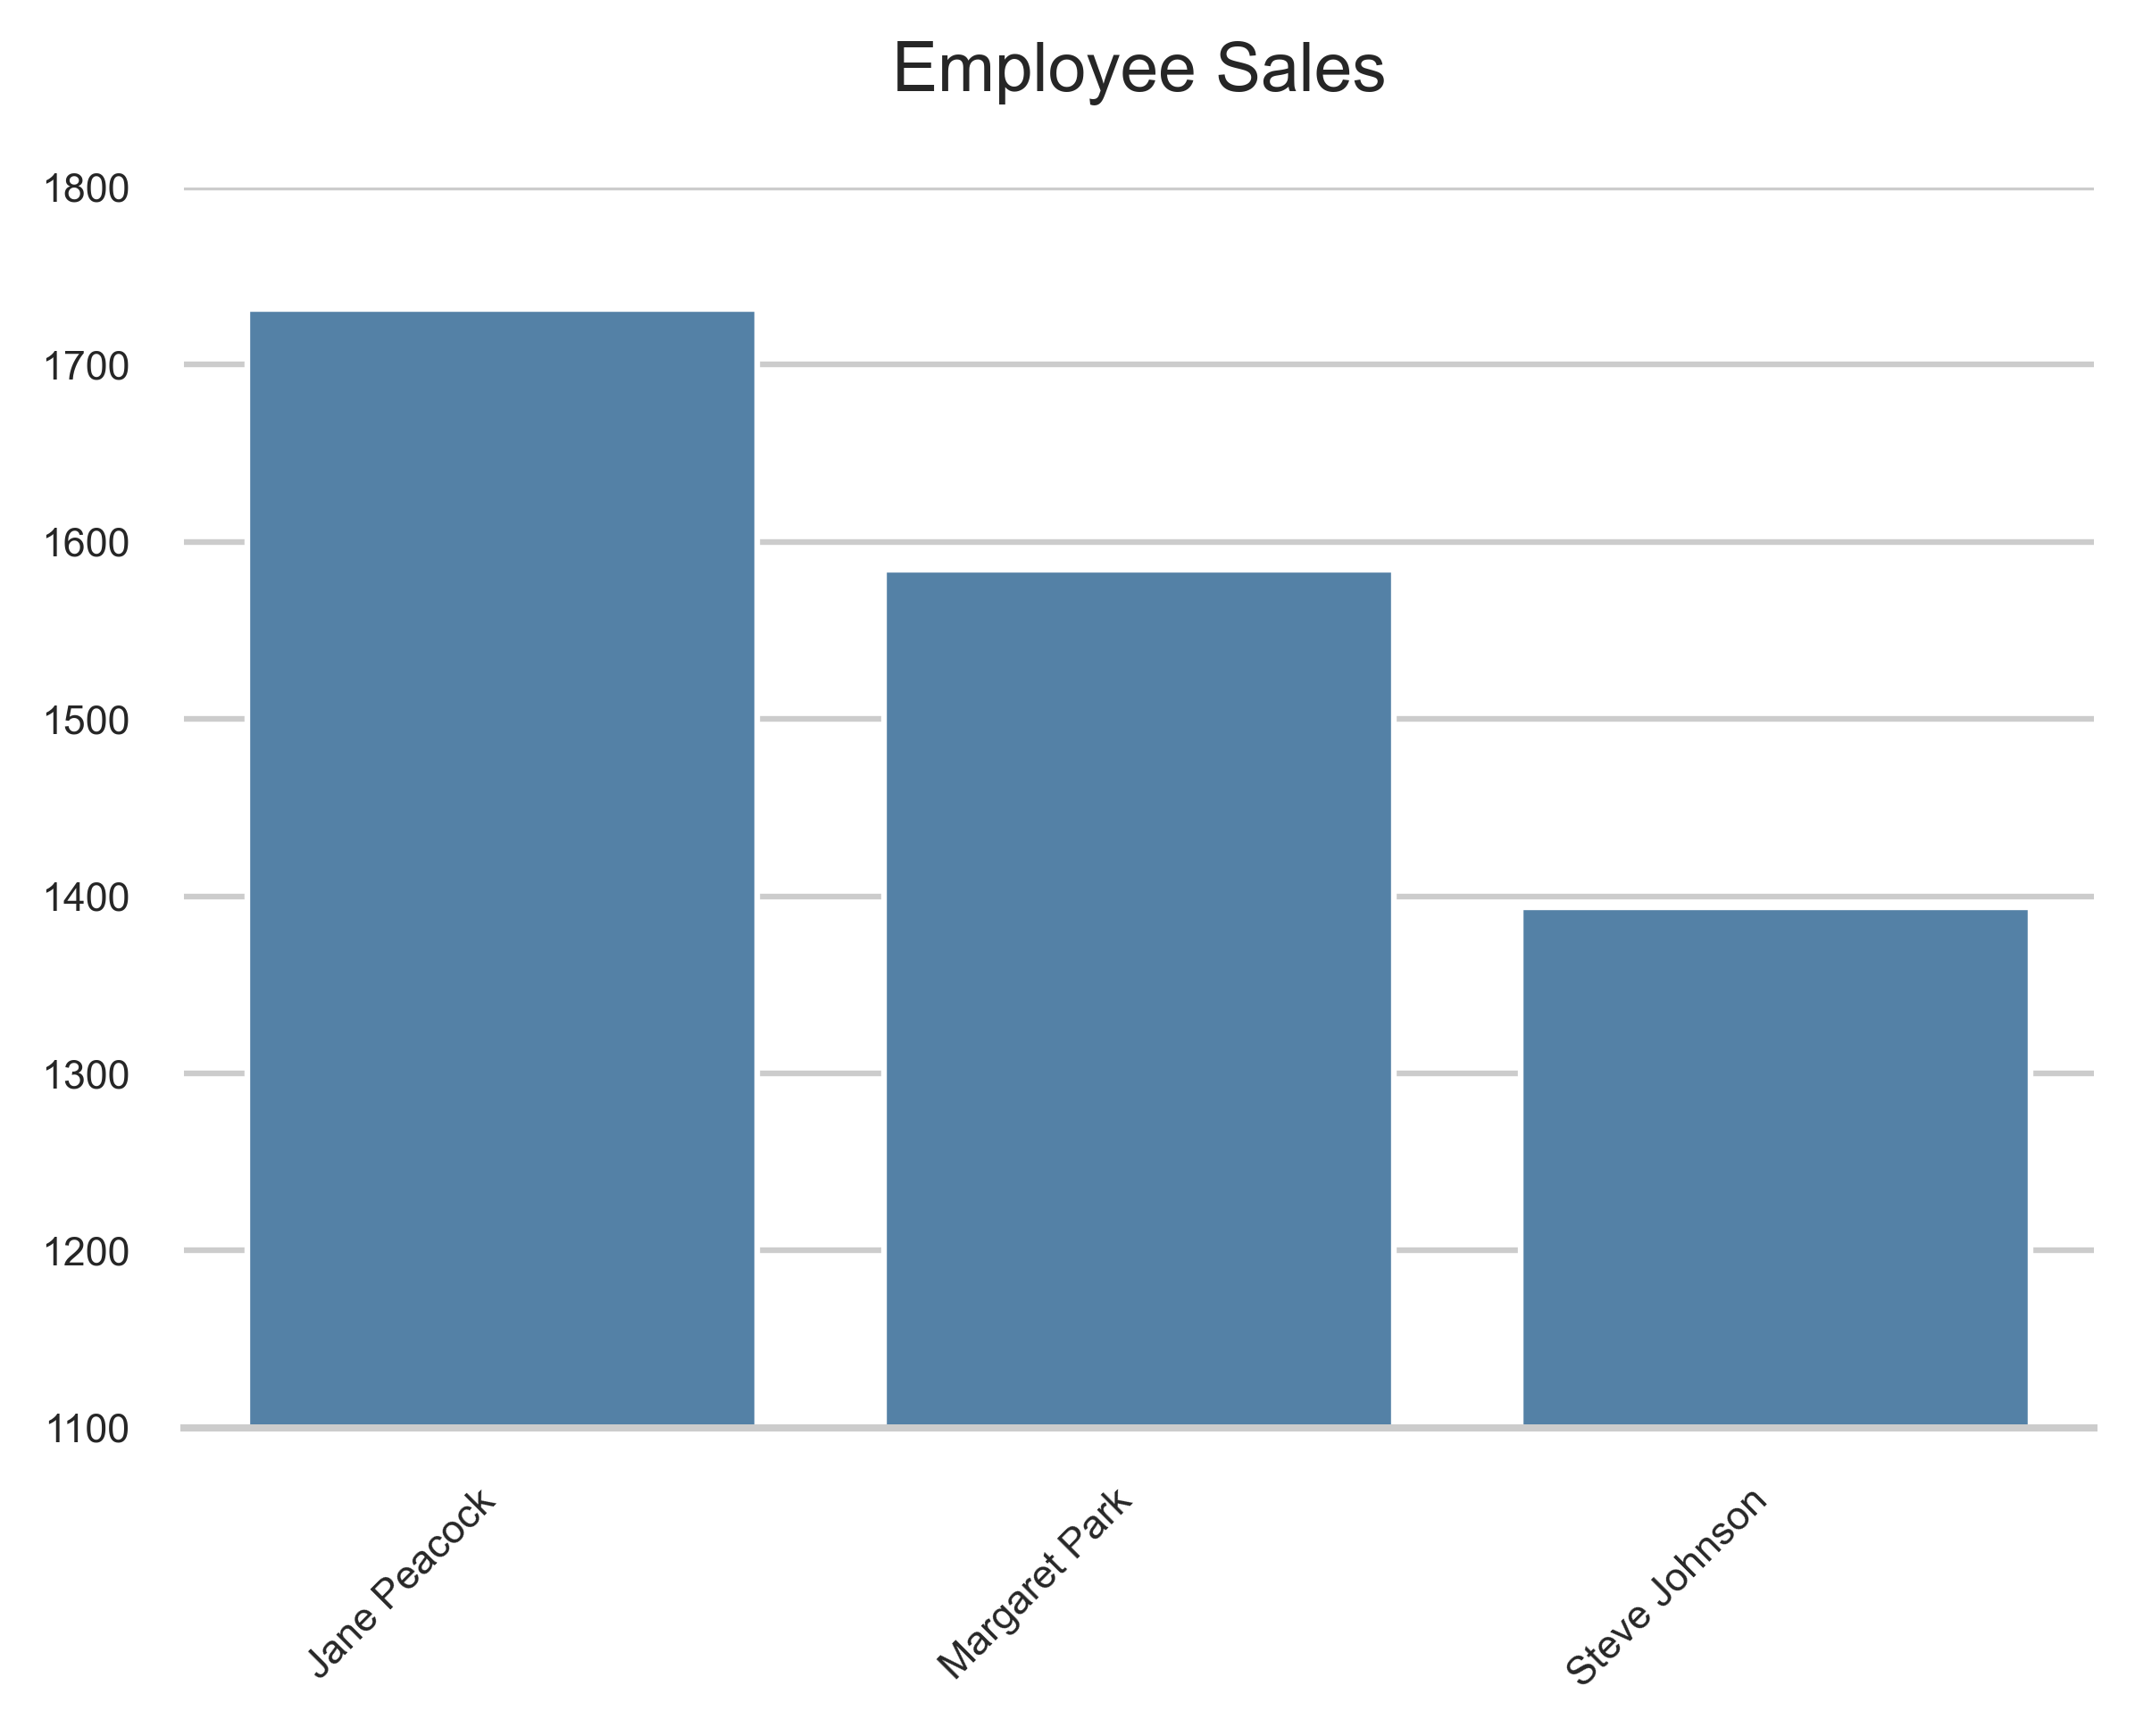

<Figure size 1840x1380 with 0 Axes>

In [25]:
# Create variable to pass into pd.read_sql
query_employee = """WITH employee_sales AS
   (
    SELECT c.support_rep_id,
           ROUND(SUM(i.total), 2) AS rep_total,
           COUNT(c.customer_id) total_customers
      FROM invoice AS i
     INNER JOIN customer AS c ON c.customer_id=i.customer_id
     GROUP BY c.support_rep_id
   )

SELECT e.first_name||" "||e.last_name AS employee_name,
       es.rep_total,
       e.hire_date
  FROM employee_sales AS es
 INNER JOIN employee AS e ON e.employee_id=es.support_rep_id;"""

# Connect to database
conn = sqlite3.connect('chinook.db')

# Read into dataframe
employee = pd.read_sql_query(query_employee, conn)

# Plot
ax = sns.barplot(x='employee_name',
                 y='rep_total',
                 data=employee,
                 color='steelblue')

# Plot Aesthetics
ax.set_title('Employee Sales', fontsize=12, y=1.05)
ax.set_ylabel('')
ax.set_xlabel('')
ax.tick_params(labelsize=7)
ax.set_ylim([1100,1800])
plt.xticks(rotation = 45, ha='right')
sns.despine(left=True)
sns.set(style='whitegrid')
plt.figure(figsize=(4, 3))

### Observations

- We can see that the sales rep with the least amount of time on the job has the least amount of sales while the rep with the longest amount of time on that job has the most.  
- This may be due to expierience or just the fact the the employee has had more time to aquire customers.   

Let's see how many customers each sales rep has:

In [26]:
%%sql

SELECT e.first_name||" "||e.last_name AS employee_name,
       COUNT(c.customer_id) AS total_customers
  FROM customer AS c
 INNER JOIN employee AS e ON e.employee_id=c.support_rep_id
 GROUP BY employee_name;

 * sqlite:///chinook.db
Done.


employee_name,total_customers
Jane Peacock,21
Margaret Park,20
Steve Johnson,18


### Observations

- While the difference is small, te most senior employee has the most customers while the least senior has the least which correlates with previous observation that the more senior employees perform better.

## Conclusions

- Based on US sales data, Chinook should sign the following artists:
    - Red Tone
    - Meteor and the Girls
    - Slim Jim Bites
- Chinook should move forward with their strategy to start purchasing the most popular tracks from an album instead of the entire album.
- Over half of the tracks in the store do not sell.  This is potentially a major problem for the business.  Chinook examine their arrangements with record labels and consider not signing any more tracks from artists with zero sales.
- The company should consider finding a way to get low selling artists in front of the eyes of the customers such as more suggestion boxes in order to increase exposure.
- The United States is largest market by sales and customer base.
- Employee sales performance correlates with time on the job.
- A song's DRM protected status does not significanlty influence a customer's tendancy to purchase that track.

## Methodology Summary

- We took data from a database with 11 tables, used SQL filter & aggregation functions  to gain insights into the business.  
- To visualize the data, we read them into a pandas dataframe, transformed them, and plotted them with the Matplotlib & Seaborn libraries.